# ML4SCI at GSoC 2025 – ML4DQM Evaluation Test
## Data Understanding and Exploration

This notebook focuses on understanding the HCAL DigiOccupancy datasets and visualizing key features that will be important for the classification task.

## Task Overview

We are provided with two synthetic datasets containing DigiOccupancy values from the Hadronic Calorimeter (HCAL) at the CMS detector:
- Run355456_Dataset.npy
- Run357479_Dataset.npy

Our objective is to develop a Vision Transformer (ViT) model to classify these "images" according to which run they originated from.

## Dataset Description

The datasets represent DigiOccupancy (hit multiplicity) values for the Hadronic Calorimeter (HCAL) at the CMS detector. Each dataset has the shape (10000, 64, 72), where:

- 10,000 refers to the number of luminosity sections (LS)
- 64 refers to the number of iEta cells (pseudorapidity)
- 72 refers to the number of iPhi cells (azimuthal angle)

Each value in the array represents the number of particle hits detected in a specific cell during a specific luminosity section.

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## 1. Loading the Datasets

First, let's download and load the datasets. For this notebook, we'll need to ensure we have the datasets in our working directory.

In [134]:
# Load the datasets
run1 = np.load("data/Run355456_Dataset_jqkne.npy")
run2 = np.load("data/Run357479_Dataset_iodic.npy")
print(f"Run1 shape: {run1.shape}")
print(f"Run2 shape: {run2.shape}")

Run1 shape: (10000, 64, 72)
Run2 shape: (10000, 64, 72)


## 2. Understanding HCAL Coordinates

Before diving into the data analysis, let's understand what iEta and iPhi represent in the HCAL detector:

### iEta (η) - Pseudorapidity
- Related to the polar angle θ by η = -ln(tan(θ/2))
- Measures position along the beam axis
- Invariant under Lorentz boosts along the beam axis
- In our dataset: 64 discrete iEta values

### iPhi (φ) - Azimuthal Angle
- Measures angular position around the beam pipe
- Covers the full 360° around the cylindrical detector
- In our dataset: 72 discrete iPhi values

The following diagram illustrates how these coordinates map to the physical HCAL detector:

```
                      ^ iEta
                      |
                      |
    +----------------+----------------+
    |                |                |
    |                |                |
    |                |                |
    |                |                |
    |                |                |
    +----------------+----------------+ --> iPhi
    |                |                |
    |                |                |
    |                |                |
    |                |                |
    |                |                |
    +----------------+----------------+
                      |
                      |
```

Each cell in this grid represents a detector cell, and the DigiOccupancy value is the number of particle hits in that cell during a luminosity section.

## 3. Basic Data Statistics

Let's calculate some basic statistics about the datasets to understand their characteristics:

In [137]:
def calculate_statistics(data, name):
    print(f"\n{name} Statistics:")
    print(f"Min value: {np.min(data)}")
    print(f"Max value: {np.max(data)}")
    print(f"Mean value: {np.mean(data):.2f}")
    print(f"Median value: {np.median(data):.2f}")
    print(f"Standard deviation: {np.std(data):.2f}")
    

    zero_percentage = (data == 0).sum() / data.size * 100
    print(f"Percentage of zero values: {zero_percentage:.2f}%")
    

    sparsity_per_image = [(img == 0).sum() / img.size * 100 for img in data]
    print(f"Average image sparsity: {np.mean(sparsity_per_image):.2f}%")
    print(f"Min image sparsity: {np.min(sparsity_per_image):.2f}%")
    print(f"Max image sparsity: {np.max(sparsity_per_image):.2f}%")

calculate_statistics(run1, "Run 355456")
calculate_statistics(run2, "Run 357479")


Run 355456 Statistics:
Min value: 0.0
Max value: 1564.944737802157
Mean value: 157.14
Median value: 0.00
Standard deviation: 364.31
Percentage of zero values: 79.77%
Average image sparsity: 79.77%
Min image sparsity: 79.77%
Max image sparsity: 79.77%

Run 357479 Statistics:
Min value: 0.0
Max value: 1091.9733311864536
Mean value: 181.08
Median value: 0.00
Standard deviation: 362.53
Percentage of zero values: 79.77%
Average image sparsity: 79.77%
Min image sparsity: 79.77%
Max image sparsity: 79.77%


## 4. Key Visualizations

Now let's create some visualizations to better understand the data:

### 4.1 Average Occupancy Maps

First, let's look at the average DigiOccupancy for each cell across all luminosity sections. This will show us which regions of the detector are typically active.

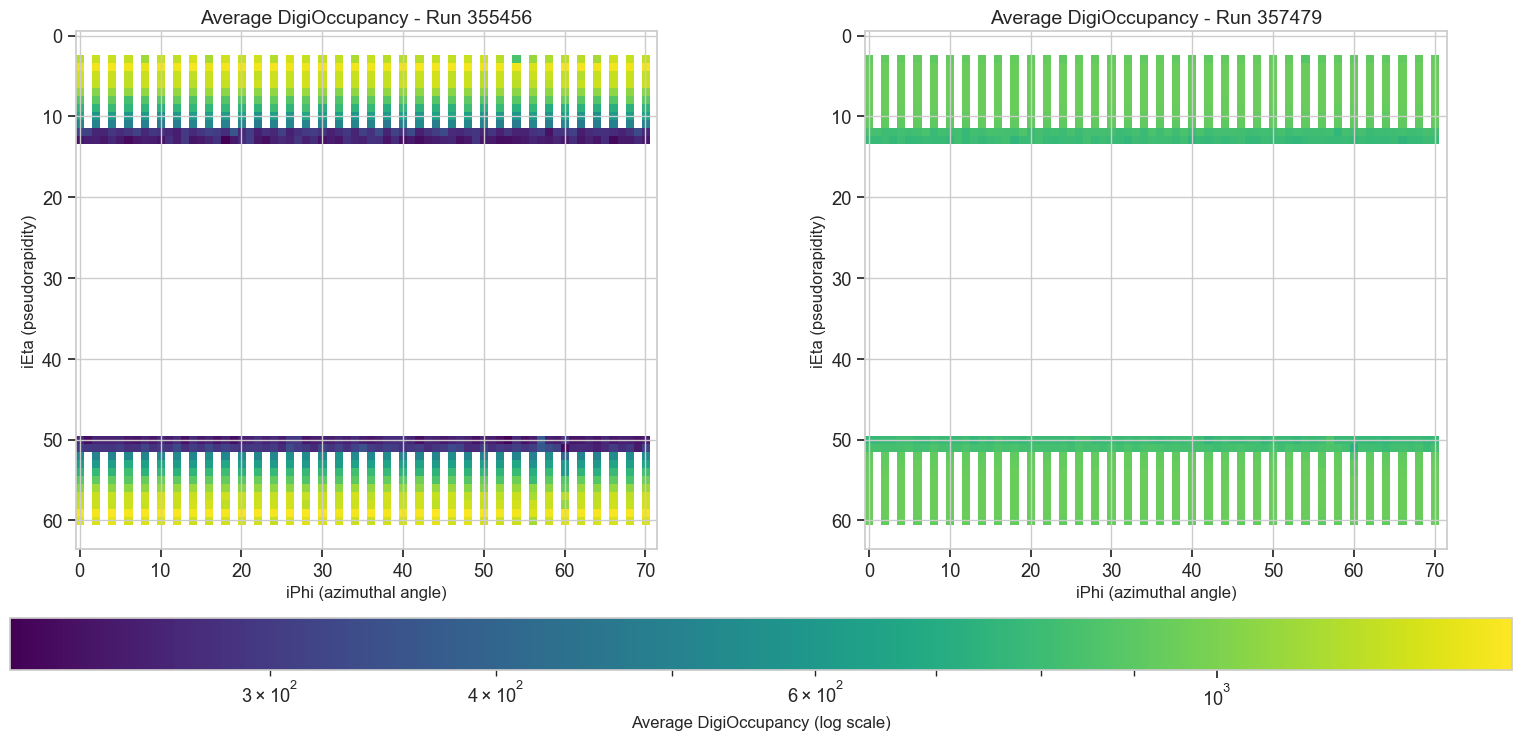

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

avg_run1 = np.mean(run1, axis=0)
avg_run2 = np.mean(run2, axis=0)

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[10, 1])  

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

vmin = min(np.min(avg_run1[avg_run1 > 0]), np.min(avg_run2[avg_run2 > 0]))
vmax = max(np.max(avg_run1), np.max(avg_run2))

im1 = ax1.imshow(avg_run1, cmap='viridis', norm=LogNorm(vmin=max(0.1, vmin), vmax=vmax))
ax1.set_title("Average DigiOccupancy - Run 355456", fontsize=14)
ax1.set_xlabel("iPhi (azimuthal angle)", fontsize=12)
ax1.set_ylabel("iEta (pseudorapidity)", fontsize=12)

im2 = ax2.imshow(avg_run2, cmap='viridis', norm=LogNorm(vmin=max(0.1, vmin), vmax=vmax))
ax2.set_title("Average DigiOccupancy - Run 357479", fontsize=14)
ax2.set_xlabel("iPhi (azimuthal angle)", fontsize=12)
ax2.set_ylabel("iEta (pseudorapidity)", fontsize=12)

cax = fig.add_subplot(gs[1, :])  
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal')
cbar.set_label('Average DigiOccupancy (log scale)', fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.savefig('images/average_occupancy_maps.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Observations from Average Occupancy Maps:

1. **Structured Activity Pattern**: Both runs show a very specific pattern of detector activity, with hits concentrated in two horizontal bands at approximately iEta positions 0-12 and 50-60.

2. **Intensity Differences**: Run 357479 generally has higher DigiOccupancy values (more hits) than Run 355456, as indicated by the more yellow/green colors versus blue/purple.

3. **Detector Structure**: The consistent pattern across both runs reveals the structural design of the HCAL detector, with active regions primarily at the edges of the iEta range.

4. **Symmetry**: There's a symmetrical pattern between the top and bottom regions of the detector, likely corresponding to the forward and backward sections of the cylindrical detector.

5. **High Sparsity**: Large portions of the detector (especially in the middle iEta region) show little to no activity.

### 4.2 Difference Map

Next, let's visualize the difference between the average occupancy maps to see which regions differ most between the two runs. This will highlight the distinguishing features for our classification task.

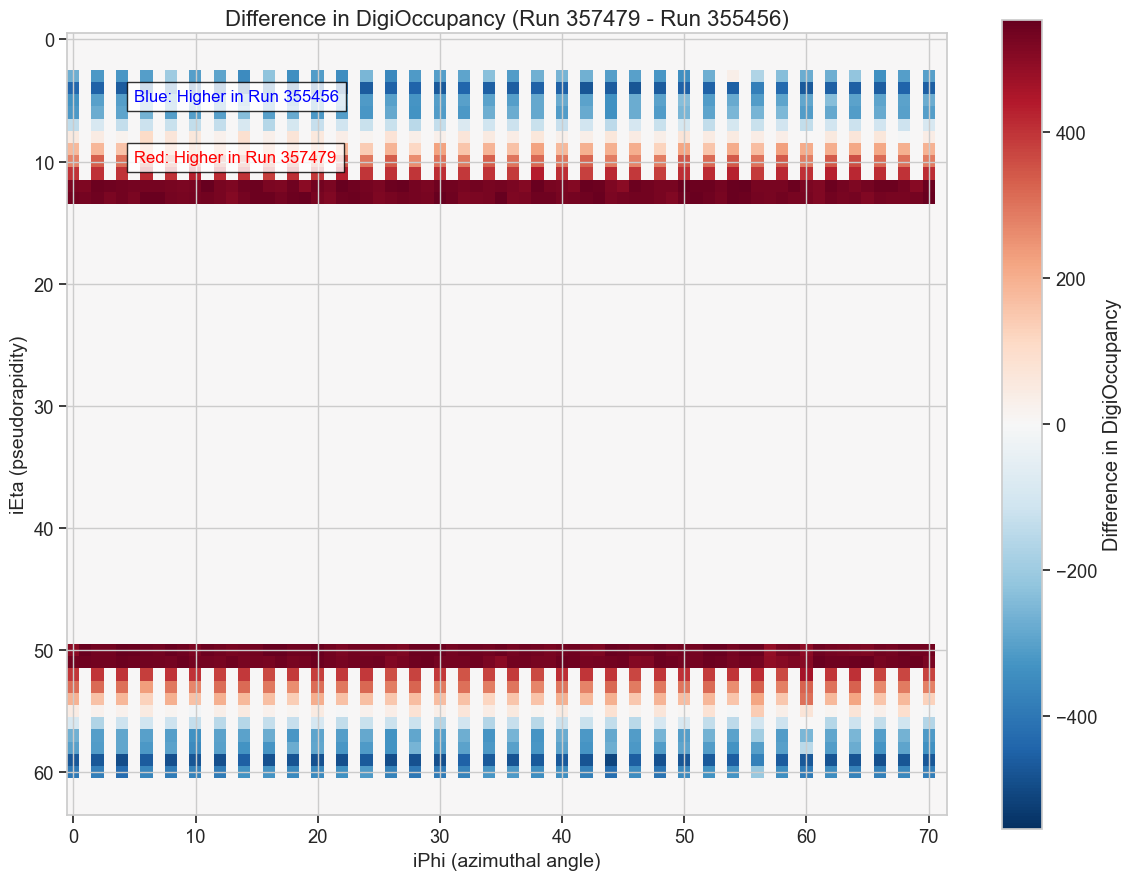

In [143]:
diff = avg_run2 - avg_run1

plt.figure(figsize=(12, 9))

vmax = max(abs(np.max(diff)), abs(np.min(diff)))

im = plt.imshow(diff, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.title("Difference in DigiOccupancy (Run 357479 - Run 355456)", fontsize=16)
plt.xlabel("iPhi (azimuthal angle)", fontsize=14)
plt.ylabel("iEta (pseudorapidity)", fontsize=14)

cbar = plt.colorbar(im, label='Difference in DigiOccupancy')

plt.text(5, 5, "Blue: Higher in Run 355456", color='blue', fontsize=12, 
         bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.text(5, 10, "Red: Higher in Run 357479", color='red', fontsize=12, 
         bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout()
plt.savefig('images/difference_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Observations from Difference Map:

1. **Systematic Differences**: The difference map reveals a systematic pattern where Run 357479 consistently has higher hit counts (red) in the middle of the active bands (iEta around 12 and 50), while Run 355456 has higher counts (blue) at the edges of these bands.

2. **Magnitude**: The difference can be quite substantial (over 400 hits in some regions) as shown by the color scale.

3. **Spatial Pattern**: The differences follow a consistent pattern across all iPhi values, suggesting that the differences between runs affect the entire detector uniformly around the azimuthal angle.

4. **Classification Features**: These systematic differences provide strong features for a Vision Transformer model to distinguish between the two runs.

5. **Strategic Importance**: The difference map highlights exactly which regions of the detector a classification model should focus on to distinguish between the runs.

### 4.3 Sample Images from Each Run

Let's look at a few random samples from each run to get a sense of what individual images look like:

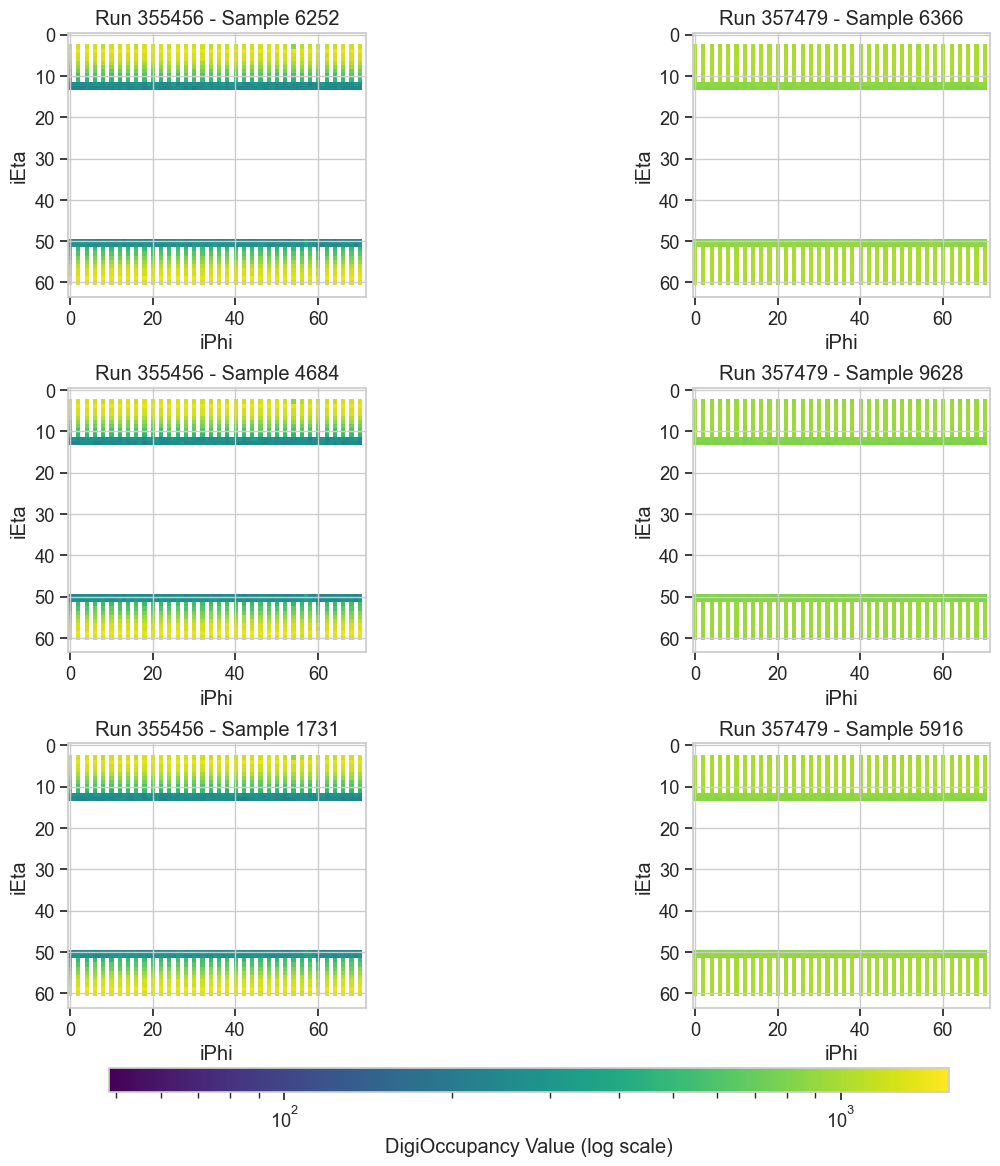

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(14, 4 * num_samples))

np.random.seed(42)  
run1_indices = np.random.choice(run1.shape[0], num_samples, replace=False)
run2_indices = np.random.choice(run2.shape[0], num_samples, replace=False)

vmin = min(np.min(run1[run1 > 0]), np.min(run2[run2 > 0]))
vmax = max(np.max(run1), np.max(run2))

for i in range(num_samples):
    im1 = axes[i, 0].imshow(run1[run1_indices[i]], 
                           cmap='viridis', 
                           norm=LogNorm(vmin=max(0.1, vmin), vmax=vmax))
    axes[i, 0].set_title(f"Run 355456 - Sample {run1_indices[i]}")
    axes[i, 0].set_xlabel("iPhi")
    axes[i, 0].set_ylabel("iEta")
    
    im2 = axes[i, 1].imshow(run2[run2_indices[i]], 
                           cmap='viridis', 
                           norm=LogNorm(vmin=max(0.1, vmin), vmax=vmax))
    axes[i, 1].set_title(f"Run 357479 - Sample {run2_indices[i]}")
    axes[i, 1].set_xlabel("iPhi")
    axes[i, 1].set_ylabel("iEta")

plt.tight_layout()
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', label='DigiOccupancy Value (log scale)')

plt.savefig('images/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Sparsity Analysis

The dataset description mentions that there will be many zero-valued entries. Let's analyze the sparsity patterns to understand where hits typically occur in the detector.

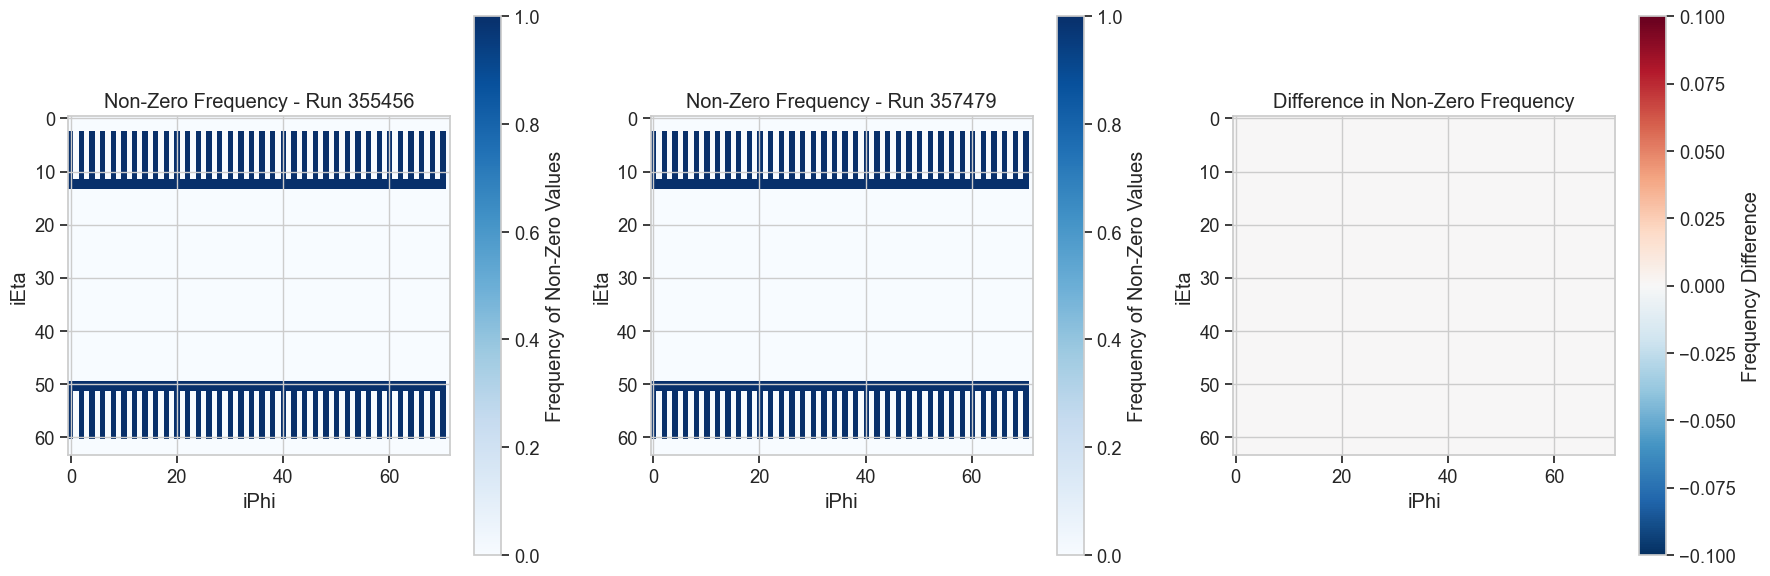

In [148]:
mask_run1 = np.mean(run1 > 0, axis=0)
mask_run2 = np.mean(run2 > 0, axis=0)

diff_mask = mask_run2 - mask_run1

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im1 = axes[0].imshow(mask_run1, cmap='Blues', vmin=0, vmax=1)
axes[0].set_title("Non-Zero Frequency - Run 355456")
axes[0].set_xlabel("iPhi")
axes[0].set_ylabel("iEta")
fig.colorbar(im1, ax=axes[0], label='Frequency of Non-Zero Values')

im2 = axes[1].imshow(mask_run2, cmap='Blues', vmin=0, vmax=1)
axes[1].set_title("Non-Zero Frequency - Run 357479") 
axes[1].set_xlabel("iPhi")
axes[1].set_ylabel("iEta")
fig.colorbar(im2, ax=axes[1], label='Frequency of Non-Zero Values')

vmax_diff = max(abs(np.min(diff_mask)), abs(np.max(diff_mask)))
im3 = axes[2].imshow(diff_mask, cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[2].set_title("Difference in Non-Zero Frequency") 
axes[2].set_xlabel("iPhi")
axes[2].set_ylabel("iEta")
fig.colorbar(im3, ax=axes[2], label='Frequency Difference')

plt.tight_layout()
plt.savefig('images/sparsity_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Observations from Sparsity Analysis:

1. **Binary Activity**: The non-zero frequency maps show exactly where activity occurs regardless of intensity, with deep blue regions indicating cells that frequently have non-zero values.

2. **Limited Active Areas**: Activity is highly concentrated in specific regions (iEta around 0-12 and 50-60), with almost no activity in the middle of the detector.

3. **Similar Activity Patterns**: Both runs have very similar patterns of where activity occurs, with the difference map showing only subtle variations.

4. **Vertical Striping**: The active regions show clear vertical stripes, indicating that for any given iPhi value, only specific iEta positions ever register hits.

5. **Preprocessing Implications**: The consistent sparsity pattern suggests that we could potentially improve model efficiency by focusing on just the active regions during preprocessing.

## 6. Value Distribution Analysis

Let's look at the distribution of non-zero DigiOccupancy values to understand the range and frequency of hit counts.

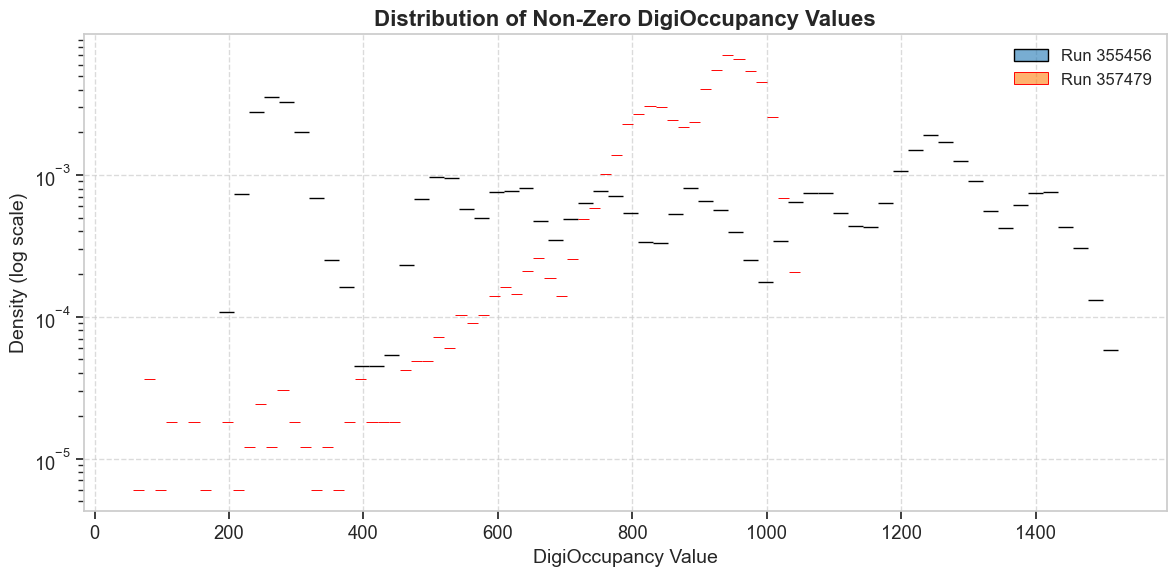

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

run1_flat = run1[run1 > 0].flatten()
run2_flat = run2[run2 > 0].flatten()

sample_size = 10000
if len(run1_flat) > sample_size:
    run1_flat = np.random.choice(run1_flat, sample_size, replace=False)
if len(run2_flat) > sample_size:
    run2_flat = np.random.choice(run2_flat, sample_size, replace=False)

sns.histplot(run1_flat, color='#1f77b4', label='Run 355456', alpha=0.6, 
             log_scale=(False, True), stat='density', bins=60, edgecolor='black')
sns.histplot(run2_flat, color='#ff7f0e', label='Run 357479', alpha=0.6, 
             log_scale=(False, True), stat='density', bins=60, edgecolor='red')

plt.xlabel('DigiOccupancy Value', fontsize=14)
plt.ylabel('Density (log scale)', fontsize=14)
plt.title('Distribution of Non-Zero DigiOccupancy Values', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('images/value_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Insights from Data Analysis

1. **Structure of Data**: The data shows highly structured patterns with activity concentrated in specific regions (iEta 0-12 and 50-60).

2. **Distinguishing Features**: The main differences between runs appear to be in the intensity patterns within the active regions rather than their locations.

3. **Symmetry**: There's a symmetrical pattern between the top and bottom regions, which may be leveraged in the model design.

4. **High Sparsity**: The majority of cells show no activity (zeros), with activity confined to specific detector regions.

### Data Preprocessing Strategies

1. **Normalization**: Given the wide range of DigiOccupancy values, normalization will be important. Options include:
   - Z-score normalization (subtract mean, divide by standard deviation)
   - Min-max scaling to [0,1] range
   - Log transformation to handle the wide dynamic range

2. **Handling Sparsity**: The high sparsity of the data (many zeros) can be addressed by:
   - Focusing on active regions only (cropping)
   - Using attention mechanisms in the ViT to focus on active regions
   - Applying thresholding to eliminate very low values that may be noise

3. **Data Augmentation**: Since we have a fixed pattern with specific active regions, traditional image augmentations like rotations or flips would distort the physical meaning. Instead, we could consider:
   - Adding small amounts of Gaussian noise to non-zero values
   - Slight scaling of intensity values
   - Randomly masking small regions to improve robustness

4. **Feature Engineering**: We might consider:
   - Calculating additional statistics per image (total hits, active cell count)
   - Extracting active regions as separate features
   - Converting to alternative representations that highlight the differences between runs

### Vision Transformer Architecture Considerations

1. **Patch Size**: Since the active regions show vertical striping patterns, we should choose a patch size that:
   - Preserves the vertical structure
   - Captures meaningful patterns without being too small
   - A patch size of 4×4 or 8×8 might be appropriate, given the 64×72 image size

2. **Attention Mechanisms**: The ViT's attention mechanism will be crucial for:
   - Focusing on the active regions and ignoring inactive areas
   - Capturing relationships between the top and bottom active bands
   - Learning the subtle differences between runs in the intensity patterns

3. **Model Complexity**: Given the structured nature of the data:
   - A moderate-sized ViT should be sufficient (6-8 transformer blocks)
   - Using multiple attention heads (8-12) to capture different aspects of the data
   - MLP dimension should be large enough to represent the complex patterns

4. **Mixture-of-Experts Option**: An MoE approach could be beneficial because:
   - Different experts could specialize in different regions of the detector
   - Some experts might focus on the top band, others on the bottom band
   - This specialization could lead to better classification performance

5. **Positional Embeddings**: Standard positional embeddings should work well as the position information is critical for understanding the spatial structure of the detector.

## 7. Next Steps

With this understanding of the data, we can proceed to develop our Vision Transformer model. In the next notebook, we will:

1. Implement data preprocessing based on our findings
2. Design and implement a Vision Transformer architecture
3. Train the model on our classification task
4. Evaluate performance using accuracy, ROC curves, and AUC
5. Experiment with both standard ViT and MoE-ViT approaches
6. Analyze the model's attention patterns to understand what features it's using for classification

The insights from this exploratory analysis will directly inform our modeling approach, particularly regarding handling of sparsity, choice of patch size, and attention mechanisms.